In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data, log, load_csv, save_csv
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "ga_training_data.csv"

log("Combining position data...", level="INFO")
combine_position_data(data_directory, seasons, positions, output_file_name)

INFO: Combining position data...
INFO: Loaded data from DEF_players.csv for season 2022-23.
INFO: Loaded data from MID_players.csv for season 2022-23.
INFO: Loaded data from FWD_players.csv for season 2022-23.
INFO: Loaded data from DEF_players.csv for season 2023-24.
INFO: Loaded data from MID_players.csv for season 2023-24.
INFO: Loaded data from FWD_players.csv for season 2023-24.
INFO: Loaded data from DEF_players.csv for season 2024-25.
INFO: Loaded data from MID_players.csv for season 2024-25.
INFO: Loaded data from FWD_players.csv for season 2024-25.
INFO: Saved CSV: Fantasy-Premier-League/data/training_data/ga_training_data.csv
INFO: Combined data saved to Fantasy-Premier-League/data/training_data/ga_training_data.csv.


INFO: Applying feature engineering...
INFO: Training model...
INFO: RMSE: 0.257646236358638
INFO: R-squared: 0.5699751973152161
INFO: Plotting feature importance...


<Figure size 1000x800 with 0 Axes>

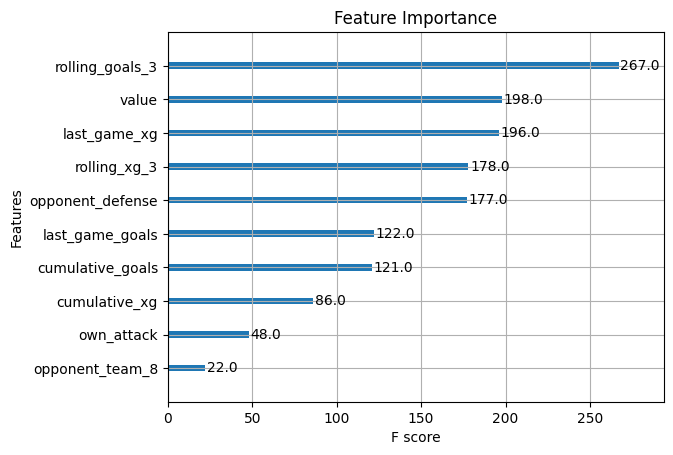

INFO: Model saved at: models/xgboost_goals_prediction_model.json


In [3]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60
ROLLING_WINDOW = 3

data = data[data['minutes'] >= MIN_MINUTES]
data['was_home'] = data['was_home'].astype(int)
data['home_crowd_effect'] = data['was_home'] * data['crowds']
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xg_3'] = data.groupby('unique_id')['expected_goals'].rolling(window=ROLLING_WINDOW, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_goals_3'] = data.groupby('unique_id')['goals_scored'].rolling(window=ROLLING_WINDOW, min_periods=1).mean().reset_index(0, drop=True)

data['last_game_goals'] = data.groupby('unique_id')['goals_scored'].shift(1)
data['last_game_xg'] = data.groupby('unique_id')['expected_goals'].shift(1)

data['cumulative_goals'] = data.groupby(['unique_id', 'season'])['goals_scored'].cumsum()
data['cumulative_xg'] = data.groupby(['unique_id', 'season'])['expected_goals'].cumsum()

# One-hot encoding for categorical features
dummy_columns = ["POS", "home_crowd_effect", "unique_id", "own_team", "opponent_team"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_xg_3", "rolling_goals_3",
    "last_game_goals", "last_game_xg",
    "cumulative_goals", "cumulative_xg"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "goals_scored"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="INFO")
        log(f"R-squared: {r2}", level="INFO")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_goals_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)

In [4]:
# # Now similar for predicting assists
# data_directory = "Fantasy-Premier-League/data/training_data"
# training_file = os.path.join(data_directory, "xga_training_data.csv")
# data = pd.read_csv(training_file)

# # Here we predict xG so we can skip the players who didn't play at all
# data = data[data['minutes'] > 60]

# # Feature engineering
# data['was_home'] = data['was_home'].astype(int)
# data['home_crowd_effect'] = data['was_home'] * data['crowds']
# data = data.sort_values(by=["unique_id", "season", "gameweek"])

# data['rolling_xa_5'] = (
#     data.groupby('unique_id')['expected_assists']
#     .shift(1)
#     .rolling(window=5, min_periods=1)
#     .mean()
#     .reset_index(level=0, drop=True)
# )

# data['rolling_xa_5'].fillna(0)


# # One-hot encoding for categorical features
# data = pd.get_dummies(data, columns=["POS", "season"], drop_first=True)

# numerical_features = [
#     "gameweek", "value", "home_crowd_effect", 
#     "opponent_defense", "own_attack", "rolling_xa_5", "unique_id"
# ]
# categorical_features = [col for col in data.columns if col.startswith("POS_") or col.startswith("season_")]
# features = numerical_features + categorical_features
# target = "expected_assists"

# X = data[features]
# y = data[target]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# model = XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=5,
#     random_state=42
# )
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# rmse = root_mean_squared_error(y_test, y_pred)
# print(f"RMSE: {rmse}")

# cv_scores = cross_val_score(
#     model,
#     X_train,
#     y_train,
#     cv=5,
#     scoring="neg_root_mean_squared_error"
# )
# cv_rmse = -np.mean(cv_scores)
# print(f"Cross-validated RMSE: {cv_rmse}")

# r2 = r2_score(y_test, y_pred)
# print(f"R-squared: {r2}")

# models_folder = "models"
# os.makedirs(models_folder, exist_ok=True)
# model_path = os.path.join(models_folder, "xgboost_xa_prediction_model.json")
# model.save_model(model_path)
# print(f"Model saved at: {model_path}")